# Example 3 - Exploring Loss Functions

In Example 2, we trained a convolutional autoencoder.  It got pretty good performance as measured by MSE loss, but we noticed that visually the reconstructions looked worse. 

In this example, we will explore what's going on and how to reconcile these two things by choosing the right loss function.

In [1]:
import tensorflow as tf


from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Identity, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping

2024-01-16 15:03:49.173736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 15:03:49.173774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 15:03:49.175289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 15:03:49.183581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 15:03:50.188837: W tensorflow/compiler/tf2

In [2]:
from utils import get_preprocessed_emoji, plot_loss, evaluate_autoencoder

In [3]:
x_train, x_test = get_preprocessed_emoji(resized_size=32)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [9]:
def make_autoencoder(x_train):
    inferred_size = x_train.shape[1]
    encoder = tf.keras.Sequential([
        Input(shape=(inferred_size, inferred_size, 3)),
    
        Conv2D(32,kernel_size=3,activation='relu',padding='same',strides=1),
        MaxPooling2D((2, 2), padding='same'),
        BatchNormalization(),
        Conv2D(64,kernel_size=3,activation='relu',padding='same',strides=1),
        MaxPooling2D((2, 2), padding='same'),
        BatchNormalization(),
        Conv2D(12,kernel_size=3,activation='relu',padding='same',strides=1), 
        MaxPooling2D((2, 2), padding='same'),
    ])
    
    # deconvolution -> decoding 
    decoder = tf.keras.Sequential([
        UpSampling2D((2, 2)),
        Conv2D(64,kernel_size=3,strides=1,activation='relu',padding='same'),
        BatchNormalization(),
        UpSampling2D((2, 2)),
        Conv2D(32,kernel_size=3,strides=1,activation='relu',padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(3,kernel_size=(3,3),activation='sigmoid',padding='same')
    ])
    
    autoencoder = tf.keras.Sequential([encoder, decoder])

    return autoencoder


## Review: The loss is better, but the recovered images look worse

This repeats the example from the previous notebook.  

Here the MSE reconstruction errors of the autoencoder appear much stronger than the baseline. However, to my eyes, the reconstructions of the baseline look slightly better.

So, we have two sets of reconstructions, and (a) our loss function tells us that one is better, but (b) our eyes tell us the other is better. 

This is happening because (a) MSE loss compares each pixel brightness independently and aggregates the differences, whereas (b) human vision focuses on shapes and contours.


In [10]:
autoencoder = make_autoencoder(x_train)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

0epoch [00:00, ?epoch/s]

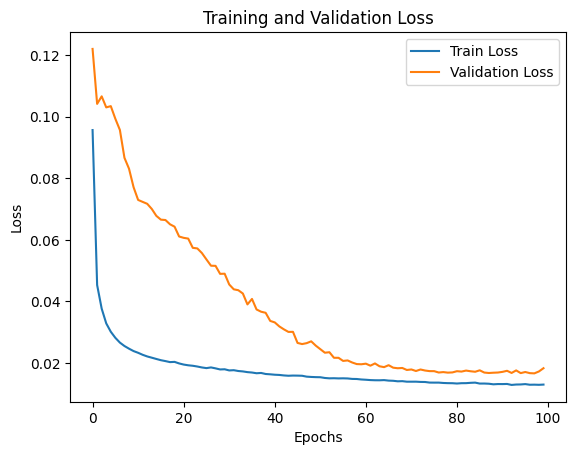

In [11]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, batch_size=256, validation_data=(x_test, x_test), 

    # Only show progress for epochs:
    verbose=0,
    callbacks=[TqdmCallback(verbose=0)],
)

plot_loss(history)

In [12]:
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 4, 4, 12)          26700     
                                                                 
 sequential_4 (Sequential)   (None, 32, 32, 3)         26563     
                                                                 
Total params: 53263 (208.06 KB)
Trainable params: 52943 (206.81 KB)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


63/63 [==============================] - 1s 6ms/step
Bottleneck layer size: 192, equivalent_downsample=8
Recovered MSE: 0.013775726780295372
Baseline MSE:  0.022099271416664124
Originals:


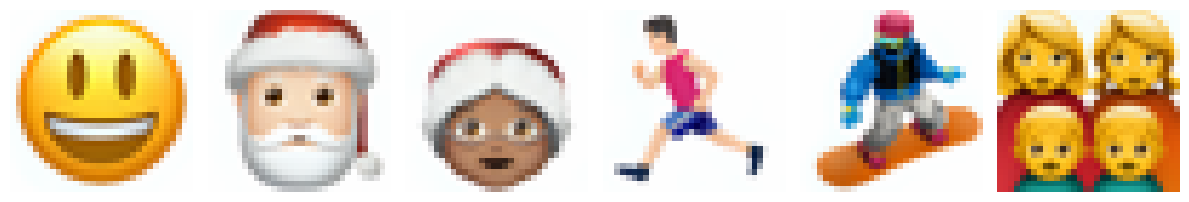

AE Recovered:


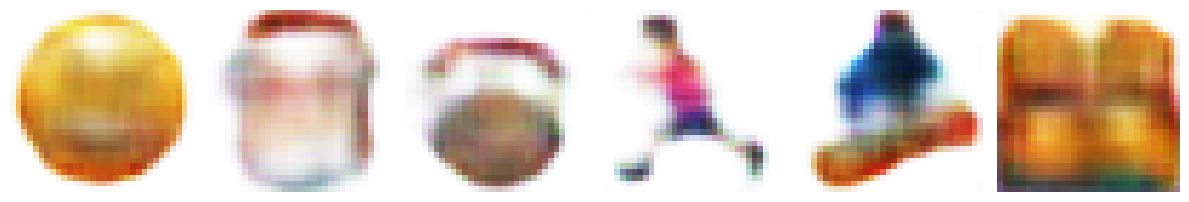

Downsample/Upsample baseline:


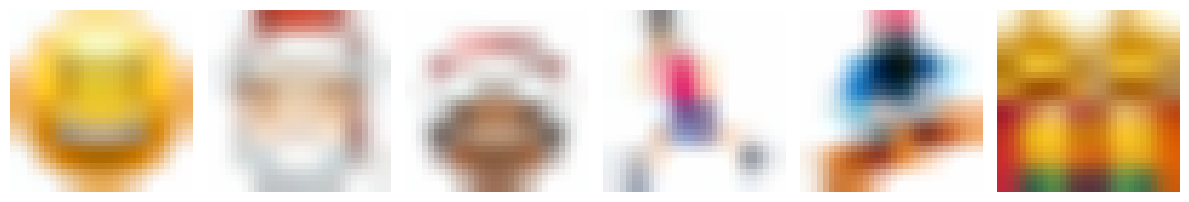

In [13]:
evaluate_autoencoder(autoencoder, x_train)

1/1 [==============================] - 0s 20ms/step


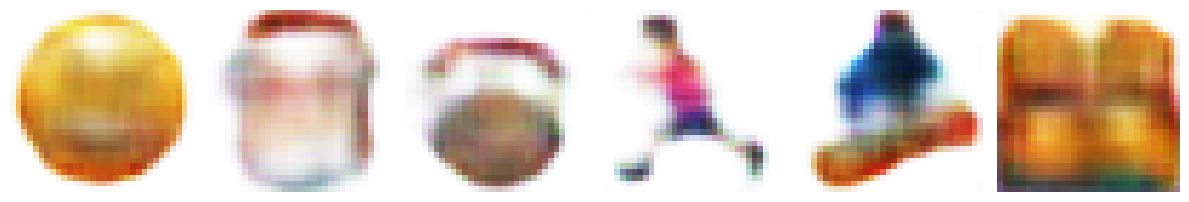

In [15]:
# Save these results to compare them later
recovered_mse_loss = autoencoder.predict(x_train[[1,4, 12, 222, 314, 612]])

from utils import view_images
view_images(recovered_mse_loss)

## Retrain with SSIM loss

Now, let's retrain the (exact same) autoencoder architecture, but use SSIM loss to train. The SSIM loss function tends to correlate better with human perception.

In [17]:
autoencoder = make_autoencoder(x_train)

def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


autoencoder.compile(optimizer='adam', loss=SSIMLoss)

0epoch [00:00, ?epoch/s]

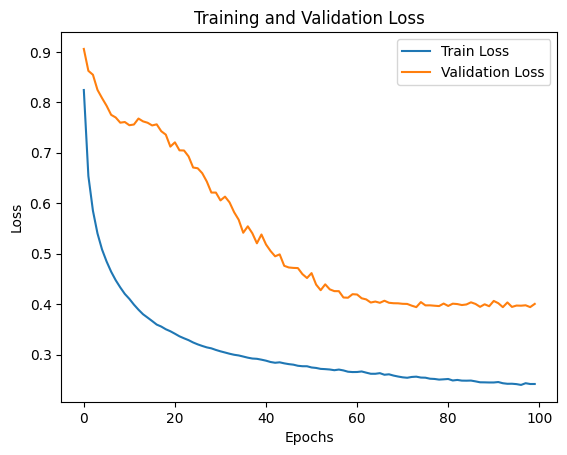

In [18]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, batch_size=256, validation_data=(x_test, x_test), 

    # Only show progress for epochs:
    verbose=0,
    callbacks=[TqdmCallback(verbose=0)],
)

plot_loss(history)

63/63 [==============================] - 0s 3ms/step
Bottleneck layer size: 192, equivalent_downsample=8
Recovered MSE: 0.018216732889413834
Baseline MSE:  0.022099271416664124
Originals:


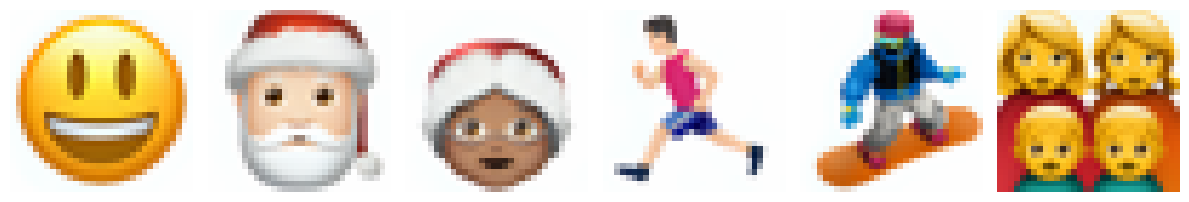

AE Recovered:


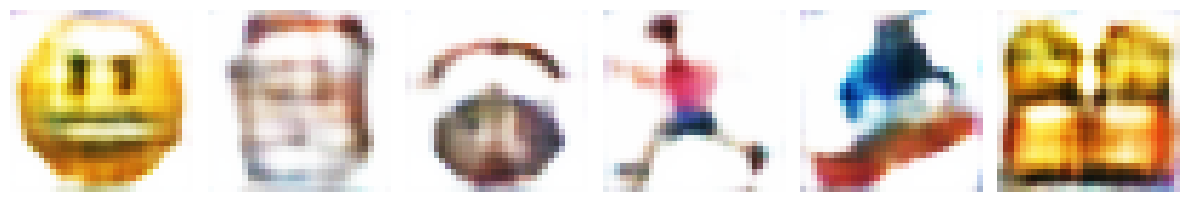

Downsample/Upsample baseline:


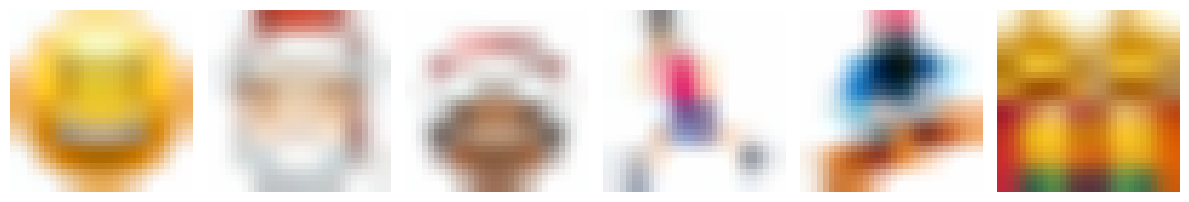

In [19]:
evaluate_autoencoder(autoencoder, x_train)

1/1 [==============================] - 0s 24ms/step
With training on SSIM loss:


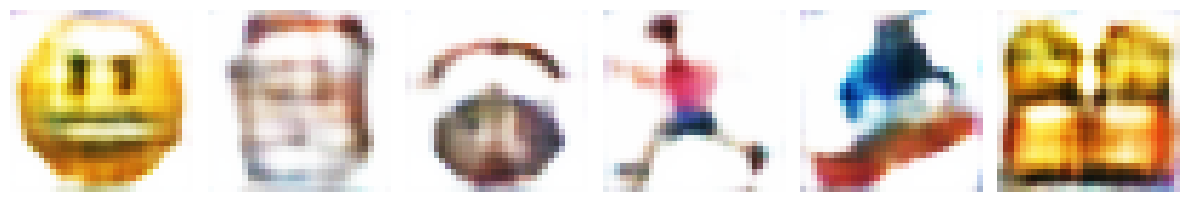

With training on MSE loss:


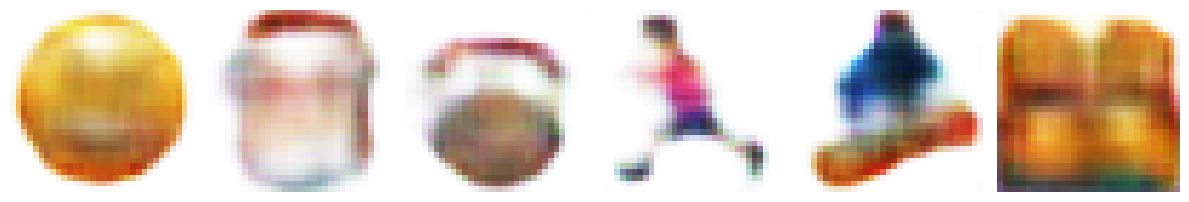

In [22]:
# Compare the reconstructions side by side

recovered_ssim_loss = autoencoder.predict(x_train[[1,4, 12, 222, 314, 612]])

from utils import view_images
print("With training on SSIM loss:")
view_images(recovered_ssim_loss)

print("With training on MSE loss:")
view_images(recovered_mse_loss)

### Subjective interpretation

To my eyes, the first set of images (reconstructions using SSIM loss) look more accurate. In particular, contours are clearer: we can see the smileys' eyes and mouth clearly, we can make out santa's eyes and mouth, and we can discern more details on each family member's face. 

### Summary

In this example, we saw that, by training on SSIM loss, the reconstructed images are clearer (**even while using the exact same autoencoder!**)  This is true even though performance as evaluated by MSE is worse (0.018 vs 0.014 earlier).

To me, this is a powerful example of how important it is to choose the right loss function!  It's often worth double-checking our intuitions, because sometimes a loss function that _seems_ reasonable is not necessarily what we want. 

This example shows that while mean-square-error seems like a reasonable way to compare two images, it doesn't accurately represent the way humans interpret images.  In this case, we find that by using a loss function designed to capture human perception of images, we can achieve better results.
